---
# **A Better Trade: Predicting Short Term Bitcoin Returns**

Forest Hensley, Jesse Marder, AJ Martinez, Brandyn Waterman

Completed as part of the Codeup Data Science program, Innis cohort (Dec 2021 - June 2022)

Submitted: June 16, 2022


---
# Executive Summary

## *Big Idea*

This project examines factors affecting short term (1 day) returns in an effort to provide traders viable strategies for profiting from cryptocurrency.

## *Goals*

1. Explore technical indicators.
2. Predict future price of bitcoin
3. Build machine learning models that incorporate analyzed features to aid in predictions

## *Key Findings*

> "The future is certain. It is just not known."
> - Johnny Rich

1. Frequency analysis revealed potential price indicators.
1. Additional modeling may be more predictive.

## *Recomendations*

1. Use descriptive statistics to indicate key price points for portfolio.
1. Explore multi-model performance.
   - i.e. SMA(15) comapared to SMA(30)

---
# Introduction

Cryptocurrencies have become much more widely adopted since 2017, with the most recent announcement by Fidelity that Bitcoin will be offered for 401ks demonstrating its potential use for mainstream investment. Still, the speculative and volatile nature of the currencies as well as extensive industry promotion efforts have resulted in many small-scale retail traders entering the market, potentially with little to no experience in the field. 

This project examines factors affecting short term (1 day) returns in an effort to provide traders viable strategies for profiting from cryptocurrency. Bitcoin price data is from Yahoo Finance and represents >7 years of daily open, high, low, and close prices as well as volume. Factors analyzed include those affecting the supply of Bitcoin such as miner revenue, xxx, and xxx as well as those affecting demand such as momentum effects, public sentiment, and technical trading rules. The factors identified 

---
# The plan

## *0. Imports*

Pulls imports from `/utils/imports.py`

In [1]:
# import all from imports.py
from imports import *

# # !!! Warning !!! 
# # *** no more warnings ***
# import warnings
# warnings.filterwarnings("ignore")

# custom mods
from tidy import *
from wrangle import *

## *1. Data Acquisition*

Data for this project was acquired from the following sources:
- Price data was acquired using Yahoo Finance and consists of data from 2014 - 2022. The csv was downloaded from the website.
- Tweets with #bitcoin and/or #btc (the ticker symbol for Bitcoin) were acquired from three different sources. 
- Early tweets from before 2019 were from a csv downloaded from Kaggle
- Tweets from 2019 - May 2022 were scraped using the snscrape library
- Data about miner features were acquired from Blockchain.com



## *2. Data Preparation*

  We conducted an initial exploration of the data by examining relationships between each of the features and treated 1 day forward log returns as the target. Next, I explored further using premier tools such as Pandas, Python, Statsmodels, etc..., to answer the initial questions posed above. Data exploration continues by delving into the descriptive statistics of the dataset. Further investigation includes up / down -sampling, frequency analysis, lag response, and autocorrelation. I found the frequency analysis revealed potential price indicators.

Data preparation consisted of the following:
- Price data was investigated 
- Tweet data was cleaned by removing nulls, converting column formats, and removed non-letter and non-digit characters.


## *3. Exploration*

Here we see the fruits of our exploration:

QUESTIONS:

With a reputation for extreme volatility Bitcoin has the potential to be a valuable market for exploiting strong price movements in a short time. Large movements in price draw media coverage and consequently additional public awareness and trader participation. Rewards may be high, but so is risk. To this end we asked how does above average volatility affect short term returns?
Method of analysis: Examined current day’s Average True Range (ATR) vs historical (14 day) ATR. ATR represents the range of prices observed between high and low, high and close, and low and close. Wider ranges imply greater volatility. Shown below is the average next day return for when the current day’s ATR is above historical ATR by the given threshold.

Average next day returns are positive when current volatility measured by ATR is higher than historical volatility and in fact reach a peak when ATR is 20% greater than average. Above 20% average returns decline and actually turn negative when volatility is very high. This analysis indicates that it could be a good time to buy for the short term when market volatility picks up but make sure you’re out of the market (or initiate a short position) if it gets very choppy. 



### Tidy Split

Pull a cached example of Binance btcusd data, tidied and split for exploration using `tidy.py`

In [2]:
# train, validate, test = btcusd()

### EDA

Exploratory data analysis of cached Binance btcusd data from `model.py`

In [3]:
df = tidy.explore_df()

cached csv


## Target analysis

Text(0.5, 0, 'Log Return')

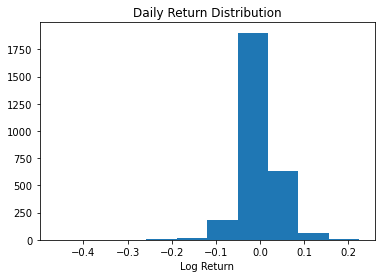

In [4]:
df.fwd_log_ret.hist(grid = False)
plt.title('Daily Return Distribution')
plt.xlabel('Log Return')

Text(0.5, 1.0, 'Classification Target Distribution - Next Day Close is Positive')

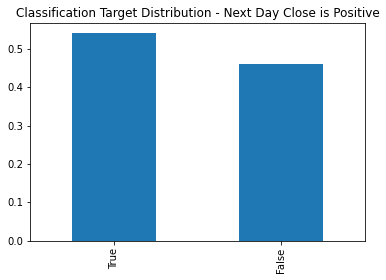

In [5]:
df.fwd_close_positive.value_counts(normalize=True).plot.bar()
plt.title('Classification Target Distribution - Next Day Close is Positive')

### When volatility is high what kind of returns are expected? 
- Measure this using ATR:
    - TR = Max[(H-L), Abs(H-Cp), Abs(L-Cp)]
    - ATR = (1/n)* sum(TRi)

In [6]:
df = tidy.add_ATR_feature(df)

In [7]:
thresholds_to_try = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
returns = {}
for threshold in thresholds_to_try:
    avg_return = tidy.perform_ATR_analysis(df, atr_threshold=threshold, make_plots=False)
    returns[threshold] = avg_return

Percentage of observations above threshold: 38.69%
Average next day return when ATR above threshold: 0.002414
which is: 1.624 times overall average
Fail to reject null hypothesis
Percentage of observations above threshold: 30.00%
Average next day return when ATR above threshold: 0.004002
which is: 2.692 times overall average
Fail to reject null hypothesis
Percentage of observations above threshold: 22.19%
Average next day return when ATR above threshold: 0.00423
which is: 2.845 times overall average
Fail to reject null hypothesis
Percentage of observations above threshold: 12.36%
Average next day return when ATR above threshold: 0.00517
which is: 3.477 times overall average
Fail to reject null hypothesis
Percentage of observations above threshold: 7.59%
Average next day return when ATR above threshold: 0.00443
which is: 2.98 times overall average
Fail to reject null hypothesis
Percentage of observations above threshold: 4.99%
Average next day return when ATR above threshold: -0.002062


Text(5, 0.0017, 'Overall Mean')

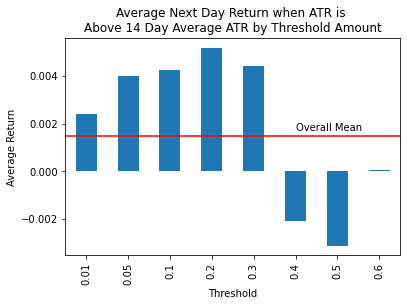

In [8]:
pd.DataFrame(returns, index = ['avg_return']).T.plot.bar(legend=False)
plt.title('Average Next Day Return when ATR is \nAbove 14 Day Average ATR by Threshold Amount')
plt.xlabel('Threshold')
plt.ylabel('Average Return')
plt.axhline(df.fwd_log_ret.mean(), color = 'r')
plt.annotate('Overall Mean', (5, 0.0017))

#### *Full Dataset Analysis*

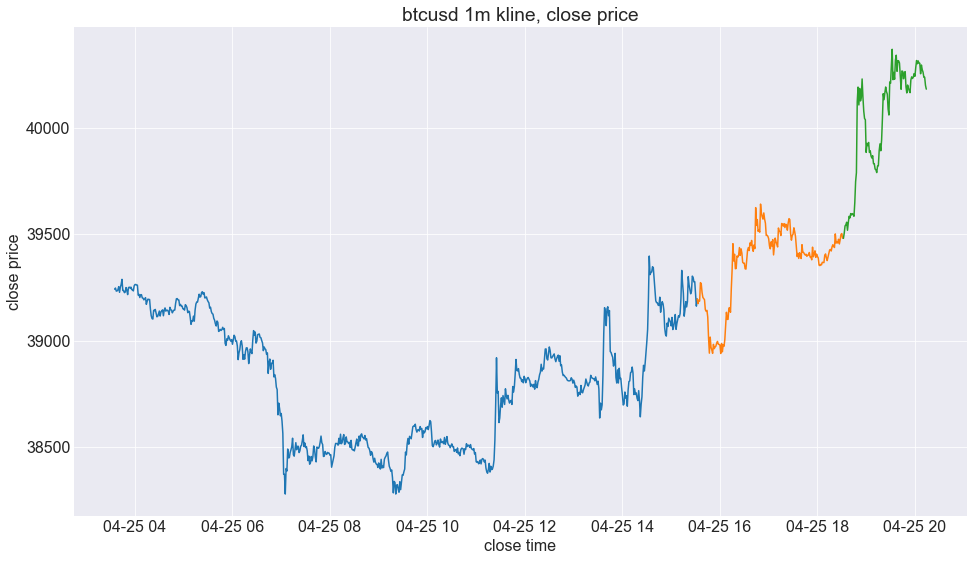

In [3]:
# plot train, validate, test split
split_plot(train,validate,test,col='close')

#### *Training Set Analysis*
Brown line is set at the average price for the period shown. Brown dots show price change every quarter hour. 


## *4. Predictive Model Analysis*

  I used data from 2022 April 26 from approximately 03:30 - 20:30 to determine if the candlestick close price, in conjuncture with the time index, could be used to determine future close prices, then modeled what the predicted values would like against the acutal values. I offer several models that attempt to predict the future price of btcusd trading pair. I used a last observed value (lov), average, 15 minute simple moving average from TAlib, and a basic Holt's linear trend. Root mean square errors (RMSE) are reported for comparison.

## *Predictive Modeling*

The graph below shows the results of the following models:
- last observed value
- average of the training set
- a quarter hour simple moving average (compliments TAlib)
- a simple Holt's linear trend.

All models are shown against the values from the validate set, which they were intended to predict.

Takeaway:
- Simple moving average was best at reducing RMSE.
- Holt's linear trend somewhat predicted the slope of the actual graph for about an hour!

/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)


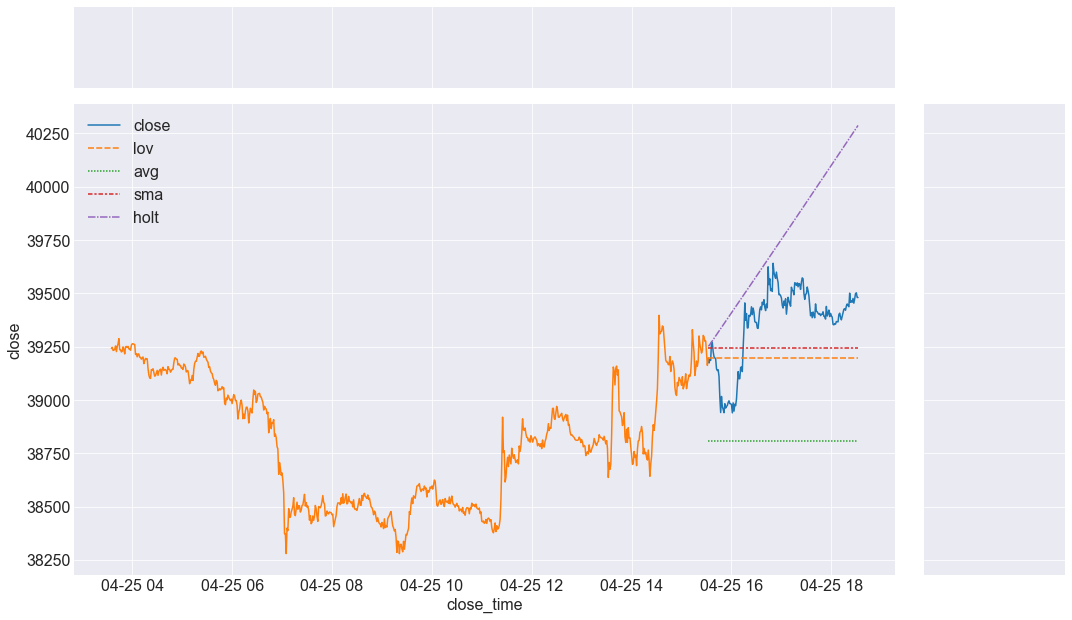

In [6]:
yhat_df=yhat_model(train,validate)

## *RMSE Analysis*

Root mean square error analysis for the models shown above. The simple moving average has the lowest error rate when predicting future prices of bitcoin. This, however, does not correlate to financially sound trading principles.

---
# Conclusion



---
# Next Steps


---
# Appendix

## *Data Dictionary*

Variables | Definition
--- | ---
 time | time candlestick opened
Open | price at open of the day
High | highest price during the day
Low | lowest price during the day
Close | price at close of the day
Volume | number of $ USD traded during interval
volume | Amount in $ USD traded for the day
fwd_log_ret | the log of tomorrow's close - the log of today's lose
fwd_close_positive | whether tomorrow's close is higher than today's
cross |
histy | 
month_9 | Encoded column for transaction during month 9 (September)
month_10 | Encoded column for transaction during month 10 (October)
day_20 | Encoded column for transaction on month day 20
day_1 | Encoded column for transaction on first day of month
day_9 | Encoded column for transaction on month day 9
atr_above_threshold_0.01 | True when today's ATR is above the historical (14 day) average ATR by 1%
atr_above_threshold_0.05 | True when today's ATR is above the historical (14 day) average ATR by 5%
atr_above_threshold_0.1 | True when today's ATR is above the historical (14 day) average ATR by 10%
atr_above_threshold_0.2 | True when today's ATR is above the historical (14 day) average ATR by 20%
atr_above_threshold_0.3 | True when today's ATR is above the historical (14 day) average ATR by 30%
avg-fees-per-transaction | Amount in $USD of average fees per transaction (by day)
cost-per-transaction-percent | 
cost-per-transaction | 
difficulty |
hash-rate |
miners-revenue |
transaction-fees-to-miners |

